## VIDEO TO FRAMES

Esta parte del código requiere la ruta donde se aloja el video, y genera los frames de los videos para el Método 1 y Método 2, no es necesario recortar los videos, o eliminar los frames (el código hace una limpieza  y no procesa los primeros y los últimos frames de cada video, es decir tomar solo los frames entre el 40% y el 80 % del video para evitar movimientos al principio o al final)

Solo cambiar la ruta del video

In [ ]:
import cv2
import os

# Carpeta con los videos a los que se les quiere extraer los frames
folder_path = r"D:\Tecnicas_observacionales\Seeing\Test_videos"
filenames = [file for file in os.listdir(folder_path)]
for filename in filenames:
    filename = filename[:-4]
    print(filename)
    video_path = os.path.join(folder_path, f"{filename}.MOV")

    video_name = os.path.splitext(os.path.basename(video_path))[
        0
    ]  # Extraer el nombre del archivo para usar como nombre de la carpeta

    output_folder = os.path.join(folder_path, "frames", video_name)  # Crear una carpeta con el nombre del video si no existe
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
        except OSError:
            print("Error: Creating directory of data")
            exit(1)

    # Abrir el video
    cam = cv2.VideoCapture(video_path)

    # Inicializar el contador de frames
    currentframe = 0

    print(f"\n Inicio de la extracción de frames")

    while True:
        # Leer un frame del video
        ret, frame = cam.read()

        if ret:
            # Si hay frames disponibles, continuar creando imágenes
            name = os.path.join(output_folder, f"frame{currentframe}.jpg")
            # print(f"Creating... {name}") #Mostrar los frames creados

            # Guardar la imagen extraída
            cv2.imwrite(name, frame)

            # Incrementar el contador de frames
            currentframe += 1
        else:
            print("\n Extracción de frames completada")
            print(f"\n {currentframe} frames generados")
            print(f"          ....            ")
            break

    # Liberar todos los recursos y cerrar ventanas una vez terminado
    cam.release()
    cv2.destroyAllWindows()

## Frames Analysis

Aquí se determina la distancia entre los spot de las estrellas del método 1 y el método 2. 

Se requiere insertar la ruta donde se guardaron los frames

Sarazin & Roddier (1990), definen la varianza en términos del movimiento total como:

$$
\sigma^{2} = 2B_{\alpha}(0,0) = 0.358 \left(\frac{\lambda}{r_0}\right)^{5/3} \left(\frac{\lambda}{D}\right)^{1/3}

$$

Donde $D$ es el diámetro de las aperturas 4.2 cm, $r_0$ es el parámetro de Fried y $\lambda$ es la longitud de onda, en este caso el visible , 0.5 $\mu$ m

Seeing :
$$
FWHM = \Delta \theta = 0.98 \lambda / r_0
$$

In [1]:
Dhole = 4.2  # diametro de la apertura  en mm
dsep = 14.4  # diametro de la separacion de las aperturas en mm
lamb = 0.00005  # longitud de onda en micrometros (cm)

In [5]:
"""________________Distance_IMG______________
Programa que construye el histograma de frecuencias de la separación 
entre dos "spots" (objetos) en el DIMM."""

"""_________________Libraries________________________"""
import cv2
import os
import glob
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance as dist
from astropy.stats import mad_std
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from tqdm import tqdm

"""__________________________________________________"""


"""__________________FUNCTIONS_______________________"""
# Definir una función con parámetros de Open CV
def identify_stars_and_distance(image_path, thresh, plot=False):
    # Cargar imagen con filtro en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    imagef = image.flatten()
    # Datos de la imagen sin los pixs menores a 5 (fondo presuntamente)
    #image_nob = imagef[np.where(imagef>5)]

    # Calcular la desviación estándar (ruido de fondo) de la imagen sin el fondo
    std, median = mad_std(image), np.median(image)
    
    # Aplicar un umbral para binarizar la imagen y destacar los objetos (estrellas) Este parámetro se puede variar según la intensidad de la estrella
    _, thresh = cv2.threshold(image, thresh*median , 255, cv2.THRESH_BINARY)

    # Encontrar los contornos de los objetos (estrellas)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar unicamente los dos contornos más grandes detectados (asumiendo que son las estrellas)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # Obtener los centros de las dos estrellas
    star_centers = []  #crear un vector para guardar los centros
    for contour in contours:
        M = cv2.moments(contour) #calcula los momentos del contorno, función de Open CV
        if M["m00"] != 0:  # moo es el area del contorno
            cX = int(M["m10"] / M["m00"])  #m10 es el momento espacial para calcular las coordenadas del centroide
            cY = int(M["m01"] / M["m00"])  #m01 es el momento espacial para calcular las coordenadas del centroide
            star_centers.append((cX, cY)) #guardar las coordenadas de los centros encontrados

    # Calcular la distancia entre las dos estrellas
    if len(star_centers) == 2:
        pixel_distance = dist.euclidean(star_centers[0], star_centers[1])
        if plot:
            # Load the image
            img = mpimg.imread(image_path)
            # Display the image
            plt.imshow(img)
            # print(star_centers)
            plt.plot([star_centers[0][0], star_centers[1][0]], [star_centers[0][1], star_centers[1][1]], 'ro', mfc='none')
            plt.tight_layout()
            plt.axis('off')
            # plt.savefig('hm.png', dpi=400)
            plt.show()        

        return(pixel_distance)
    else:
        # print("No se encontraron estrellas.")
        return 0

# Definir una funcion para extraer el numero del frame del nombre del archivo
def extract_frame_number(filename):
    match = re.search(r'frame(\d+)\.jpg', filename)
    return int(match.group(1)) if match else -1

Corrección por video

Factor de recorte, 6000/1920 = 3.125
Por relación de frame del video con tamaño captura


Unidades radianes o unidades de angulo
Longitudinal o transversal




G-1_altair_270824_21_09_DSC_0019_mascara
Se encontraron 2802 frames(.jpg) se procesarán del 2185 al 2241

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 36.516 pixeles, Desviación estándar (σ): 0.923 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.034 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.174

El parámetro de Fried es :4.03 cm 

El valor del seeing sin la corrección al cenit es de: 2.507


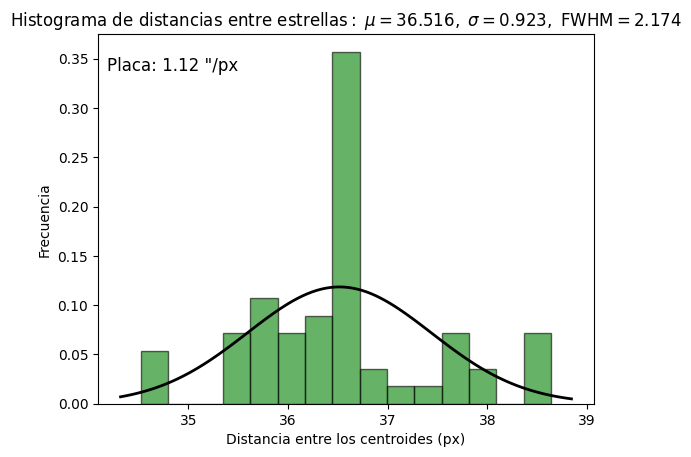

G-1_altair_270824_21_15_DSC_0019_mascara
Se encontraron 2172 frames(.jpg) se procesarán del 1694 al 1737

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 37.002 pixeles, Desviación estándar (σ): 0.912 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.021 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.147

El parámetro de Fried es :4.09 cm 

El valor del seeing sin la corrección al cenit es de: 2.469


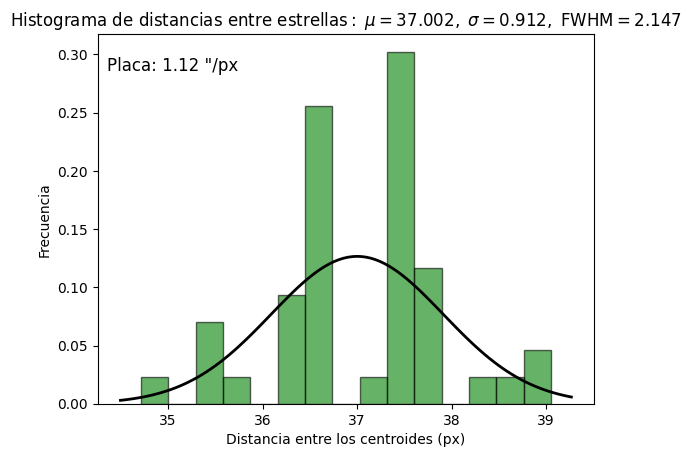

G-1_altair_270824_21_30_DSC_0019_mascara
Se encontraron 2238 frames(.jpg) se procesarán del 1745 al 1790

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 37.122 pixeles, Desviación estándar (σ): 0.879 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.984 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.069

El parámetro de Fried es :4.28 cm 

El valor del seeing sin la corrección al cenit es de: 2.362


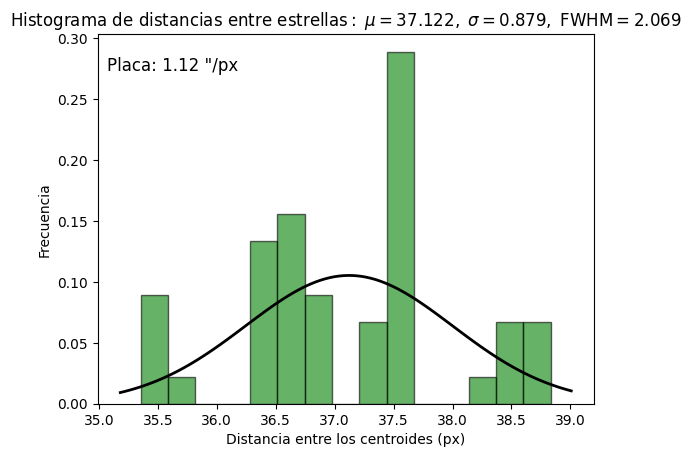

G-1_altair_270824_21_40_DSC_0019_prisma
Se encontraron 2286 frames(.jpg) se procesarán del 1783 al 1828

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 831.893 pixeles, Desviación estándar (σ): 1.012 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.133 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.383

El parámetro de Fried es :3.61 cm 

El valor del seeing sin la corrección al cenit es de: 2.798


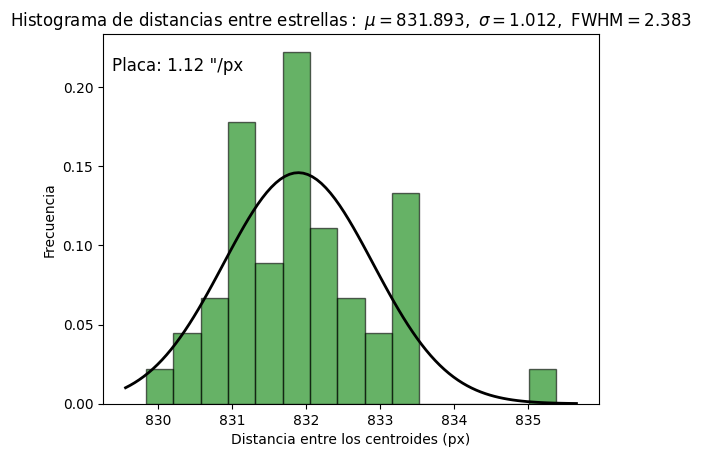

G-1_altair_270824_21_45_DSC_0019_prisma
Se encontraron 2184 frames(.jpg) se procesarán del 1703 al 1747

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 851.484 pixeles, Desviación estándar (σ): 1.090 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.220 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.566

El parámetro de Fried es :3.31 cm 

El valor del seeing sin la corrección al cenit es de: 3.058


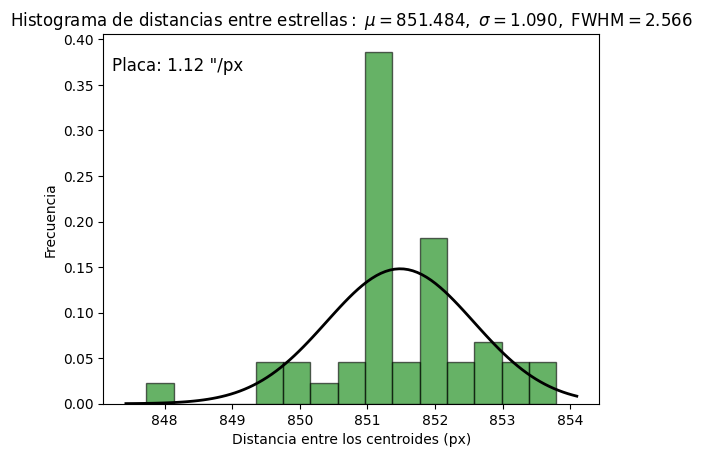

G-2_KausAustralis_270824_LT210400_Mascara
Se encontraron 6120 frames(.jpg) se procesarán del 4773 al 4896

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 38.456 pixeles, Desviación estándar (σ): 1.191 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.334 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.804

El parámetro de Fried es :2.97 cm 

El valor del seeing sin la corrección al cenit es de: 3.401


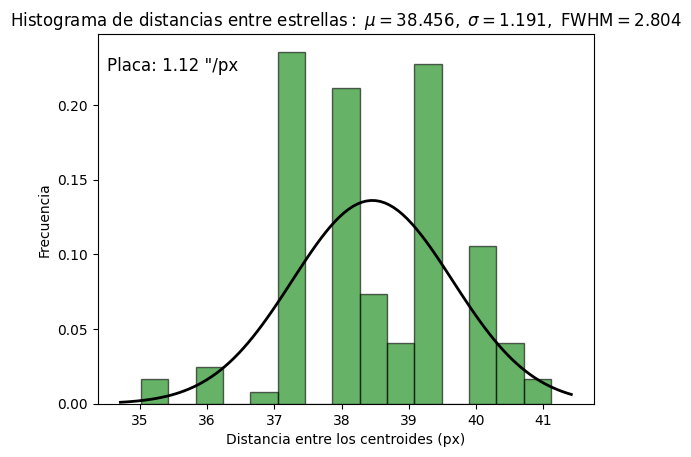

G-2_KausAustralis_270824_LT210900_Prisma
Se encontraron 6357 frames(.jpg) se procesarán del 4958 al 5085

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 700.882 pixeles, Desviación estándar (σ): 1.242 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.391 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.925

El parámetro de Fried es :2.82 cm 

El valor del seeing sin la corrección al cenit es de: 3.578


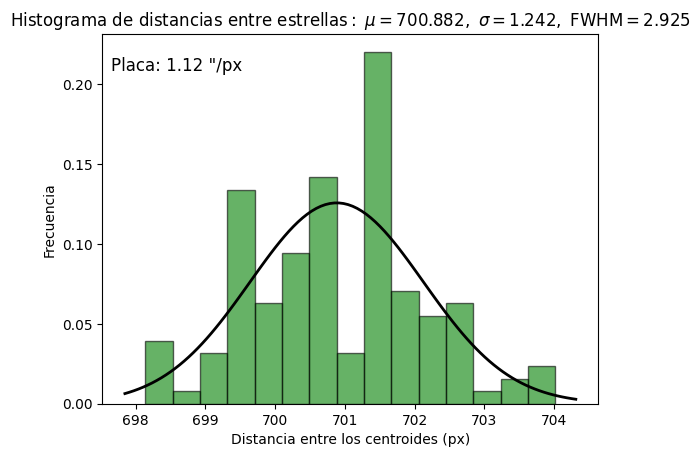

G-2_Sabik_270824_LT203300_Prisma
Se encontraron 6780 frames(.jpg) se procesarán del 5288 al 5424

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 735.088 pixeles, Desviación estándar (σ): 0.933 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.045 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.198

El parámetro de Fried es :3.98 cm 

El valor del seeing sin la corrección al cenit es de: 2.540


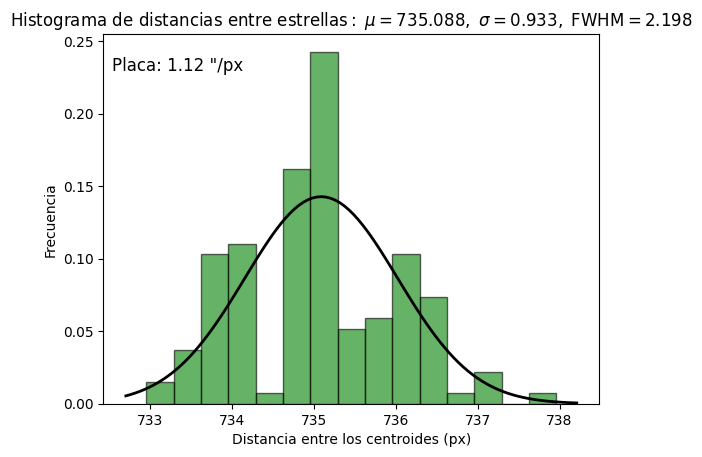

G-2_Sabik_270824_LT203300_Prisma_conf
Se encontraron 5562 frames(.jpg) se procesarán del 4338 al 4449

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 754.809 pixeles, Desviación estándar (σ): 1.152 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.291 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.714

El parámetro de Fried es :3.09 cm 

El valor del seeing sin la corrección al cenit es de: 3.271


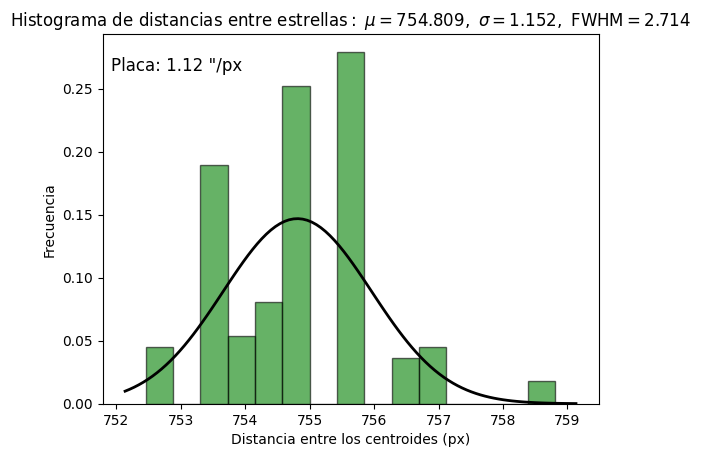

G-2_Sabik_270824_LT204800_Mascara
Se encontraron 5565 frames(.jpg) se procesarán del 4340 al 4452

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 40.606 pixeles, Desviación estándar (σ): 0.821 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.920 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.934

El parámetro de Fried es :4.64 cm 

El valor del seeing sin la corrección al cenit es de: 2.178


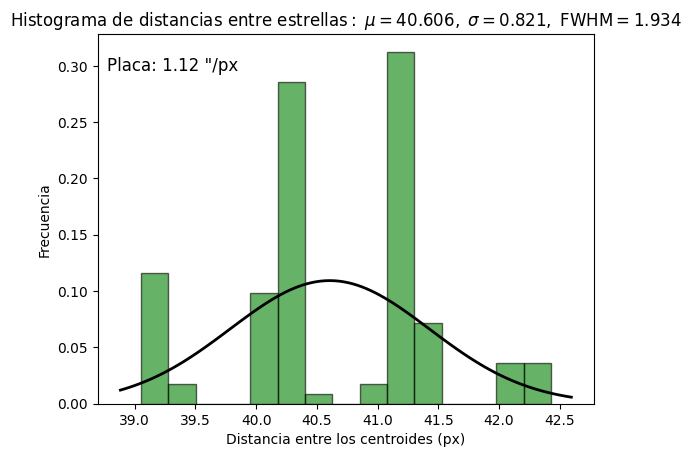

G-2_Vega_270824_LT200500_Mascara
Se encontraron 5604 frames(.jpg) se procesarán del 4371 al 4483

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 28.013 pixeles, Desviación estándar (σ): 0.799 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.895 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.881

El parámetro de Fried es :4.80 cm 

El valor del seeing sin la corrección al cenit es de: 2.107


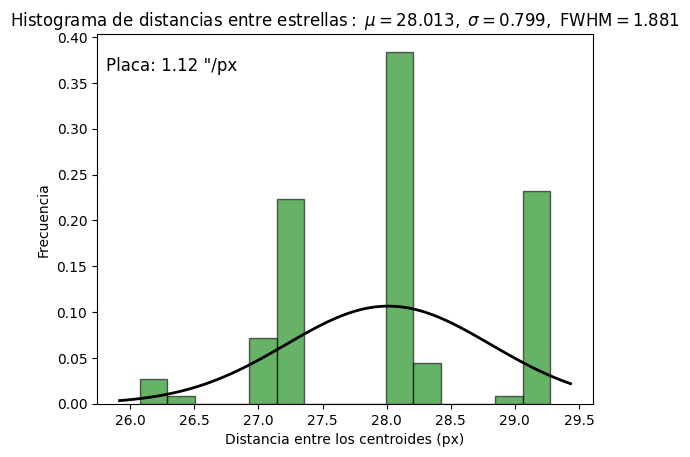

G-2_Vega_270824_LT201000_Prisma
Se encontraron 5808 frames(.jpg) se procesarán del 4530 al 4646

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 53.565 pixeles, Desviación estándar (σ): 0.926 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.037 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.180

El parámetro de Fried es :4.02 cm 

El valor del seeing sin la corrección al cenit es de: 2.514


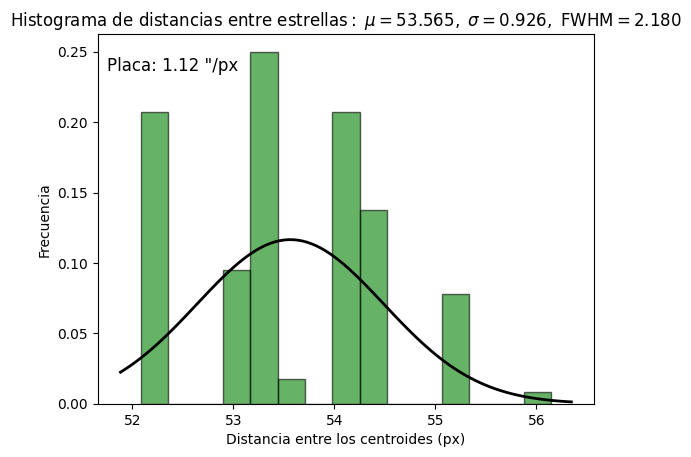

G-2_Vega_270824_LT203700_Prisma
Se encontraron 7476 frames(.jpg) se procesarán del 5831 al 5980

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 734.759 pixeles, Desviación estándar (σ): 0.913 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.023 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.151

El parámetro de Fried es :4.08 cm 

El valor del seeing sin la corrección al cenit es de: 2.475


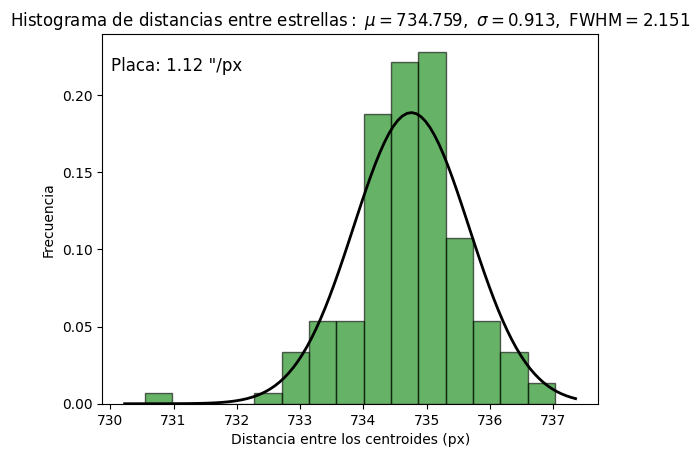

G_3_Altair_190924_19_22_DSC_0049_Prisma
Se encontraron 7680 frames(.jpg) se procesarán del 5990 al 6144

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 815.840 pixeles, Desviación estándar (σ): 1.025 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.148 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.415

El parámetro de Fried es :3.56 cm 

El valor del seeing sin la corrección al cenit es de: 2.843


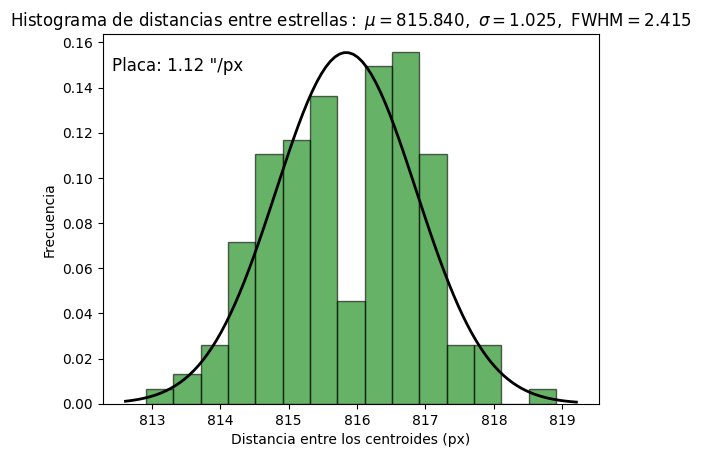

G_3_Altair_190924_19_28_DSC0050_Mascara
Se encontraron 7455 frames(.jpg) se procesarán del 5814 al 5964

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 37.157 pixeles, Desviación estándar (σ): 0.953 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.067 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.244

El parámetro de Fried es :3.88 cm 

El valor del seeing sin la corrección al cenit es de: 2.604


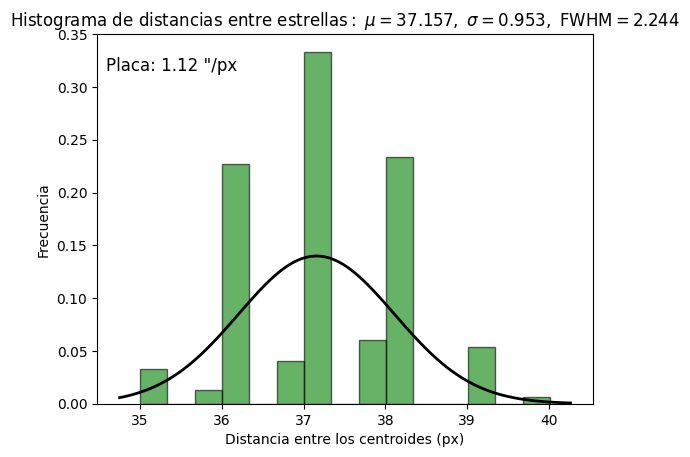

G_3_Altair_190924_20_24_DSC0064_Prisma
Se encontraron 7641 frames(.jpg) se procesarán del 5959 al 6112

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 809.506 pixeles, Desviación estándar (σ): 0.790 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.885 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.861

El parámetro de Fried es :4.86 cm 

El valor del seeing sin la corrección al cenit es de: 2.080


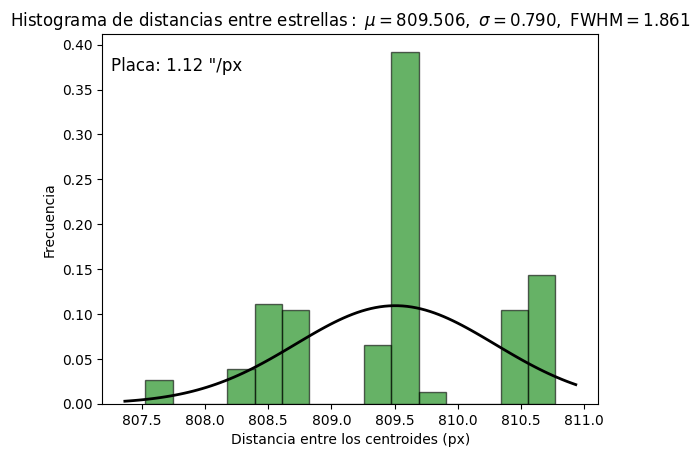

G_3_Altair_190924_20_29_DSC0065_Mascara
Se encontraron 7908 frames(.jpg) se procesarán del 6168 al 6326

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 25.404 pixeles, Desviación estándar (σ): 0.729 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.816 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.716

El parámetro de Fried es :5.36 cm 

El valor del seeing sin la corrección al cenit es de: 1.887


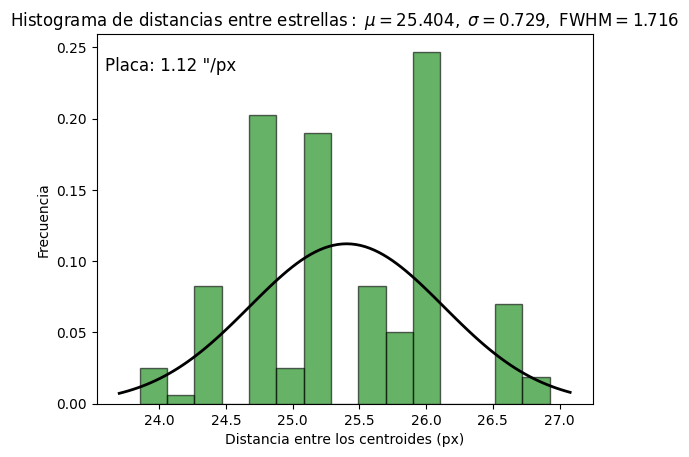

G_3_Altair_190924_21_28_DSC0080_Prisma
Se encontraron 7872 frames(.jpg) se procesarán del 6140 al 6297

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 811.001 pixeles, Desviación estándar (σ): 0.684 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.766 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.610

El parámetro de Fried es :5.78 cm 

El valor del seeing sin la corrección al cenit es de: 1.748


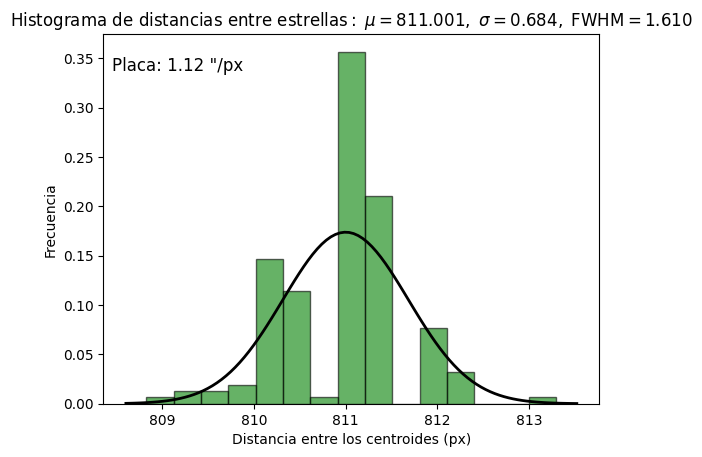

G_3_Altair_190924_21_33_DSC0081_Mascara
Se encontraron 7908 frames(.jpg) se procesarán del 6168 al 6326

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 20.334 pixeles, Desviación estándar (σ): 0.568 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.636 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.338

El parámetro de Fried es :7.22 cm 

El valor del seeing sin la corrección al cenit es de: 1.400


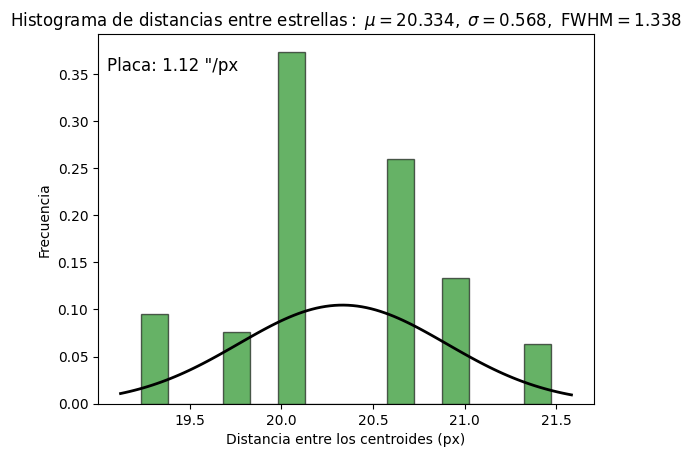

G_3_Altair_190924_23_07_DSC0093_Mascara
Se encontraron 7953 frames(.jpg) se procesarán del 6203 al 6362

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 29.546 pixeles, Desviación estándar (σ): 0.783 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.877 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.844

El parámetro de Fried es :4.91 cm 

El valor del seeing sin la corrección al cenit es de: 2.057


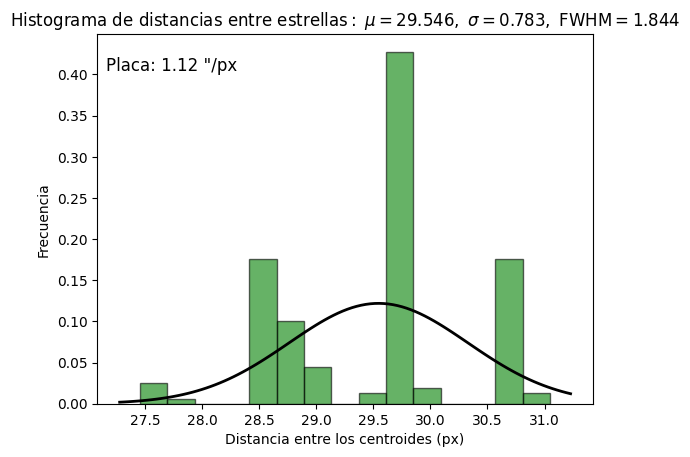

G_3_Altair_190924_23_14_DSC0094_Prisma
Se encontraron 8226 frames(.jpg) se procesarán del 6416 al 6580

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 812.625 pixeles, Desviación estándar (σ): 1.003 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.123 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.361

El parámetro de Fried es :3.65 cm 

El valor del seeing sin la corrección al cenit es de: 2.767


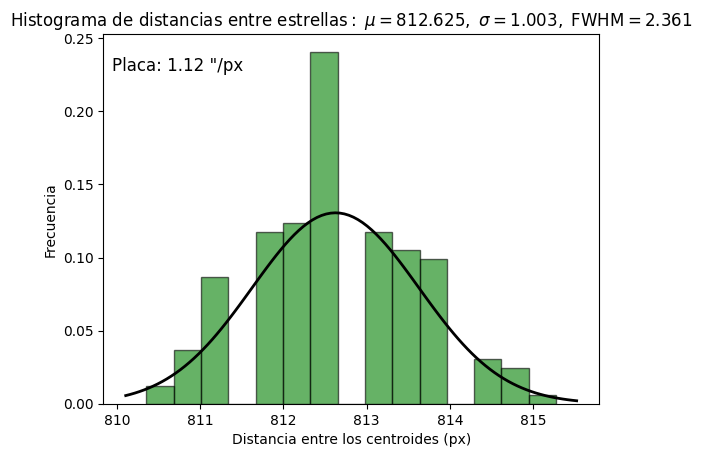

G_3_Altair_190924_23_38_DSC0096_Prisma
Se encontraron 7818 frames(.jpg) se procesarán del 6098 al 6254

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 813.477 pixeles, Desviación estándar (σ): 1.578 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.767 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 3.716

El parámetro de Fried es :2.12 cm 

El valor del seeing sin la corrección al cenit es de: 4.769


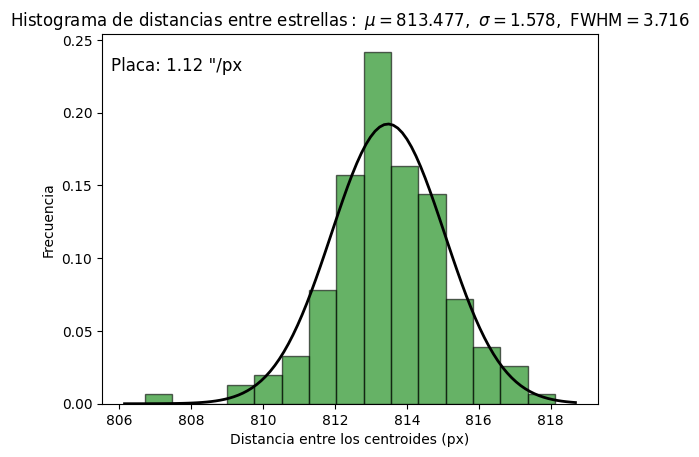

G_3_Altair_190924_23_42_DSC0097_Mascara
Se encontraron 7626 frames(.jpg) se procesarán del 5948 al 6100

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 33.206 pixeles, Desviación estándar (σ): 1.298 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.454 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 3.058

El parámetro de Fried es :2.68 cm 

El valor del seeing sin la corrección al cenit es de: 3.774


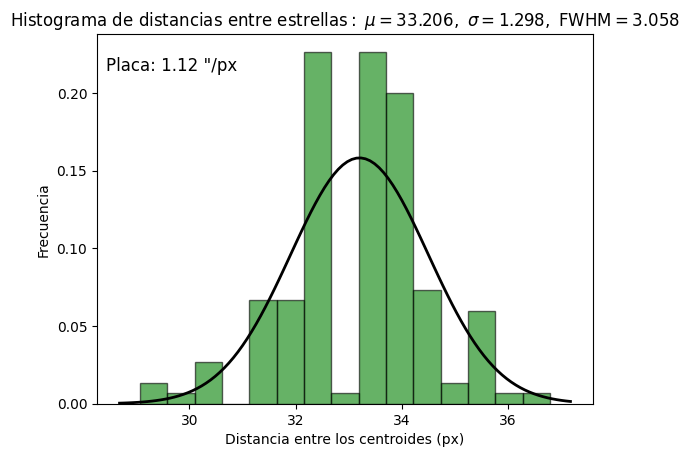

G_3_Altair_290824_22_25_DSC0026_Prisma
Se encontraron 8775 frames(.jpg) se procesarán del 6844 al 7020

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 834.572 pixeles, Desviación estándar (σ): 0.826 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.925 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.945

El parámetro de Fried es :4.61 cm 

El valor del seeing sin la corrección al cenit es de: 2.193


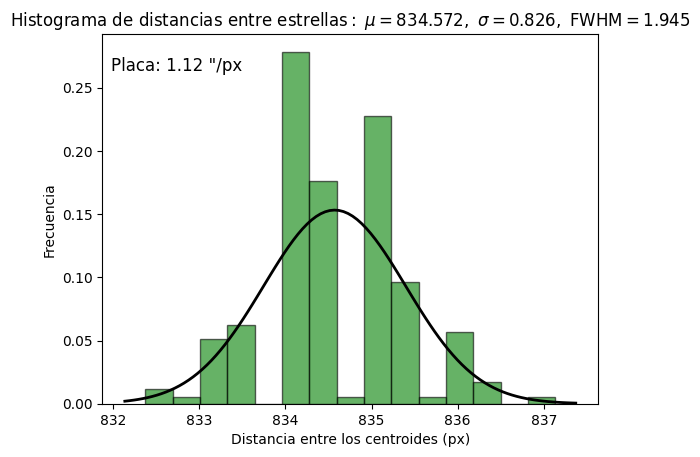

G_3_Altair_290824_22_30_DSC0027_Mascara
Se encontraron 8511 frames(.jpg) se procesarán del 6638 al 6808

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 34.920 pixeles, Desviación estándar (σ): 1.219 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.366 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.872

El parámetro de Fried es :2.89 cm 

El valor del seeing sin la corrección al cenit es de: 3.500


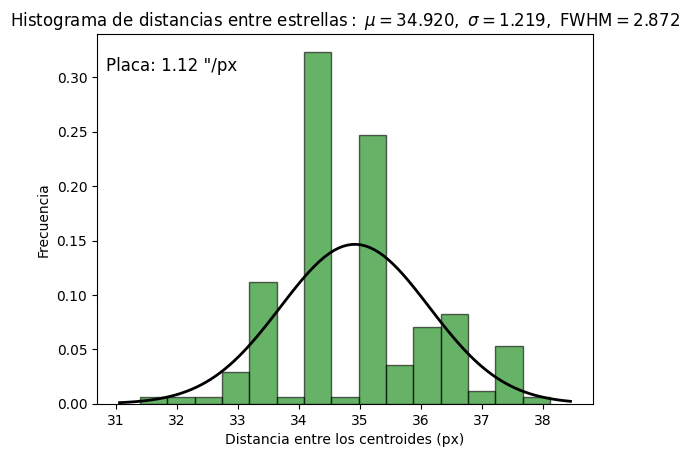

G_3_Altair_290824_22_35_DSC0028_Mascara
Se encontraron 8670 frames(.jpg) se procesarán del 6762 al 6936

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 34.743 pixeles, Desviación estándar (σ): 1.113 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.247 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.621

El parámetro de Fried es :3.22 cm 

El valor del seeing sin la corrección al cenit es de: 3.137


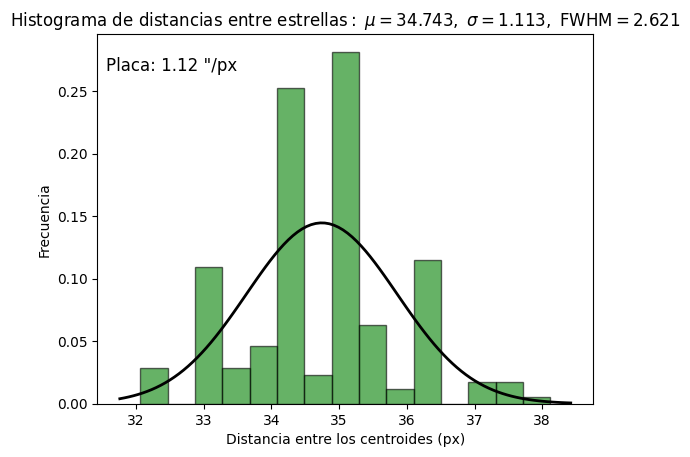

G_3_Altair_300824_21_38_DSC0034_Mascara
Se encontraron 8484 frames(.jpg) se procesarán del 6617 al 6787

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 12.865 pixeles, Desviación estándar (σ): 0.658 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.737 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.549

El parámetro de Fried es :6.06 cm 

El valor del seeing sin la corrección al cenit es de: 1.669


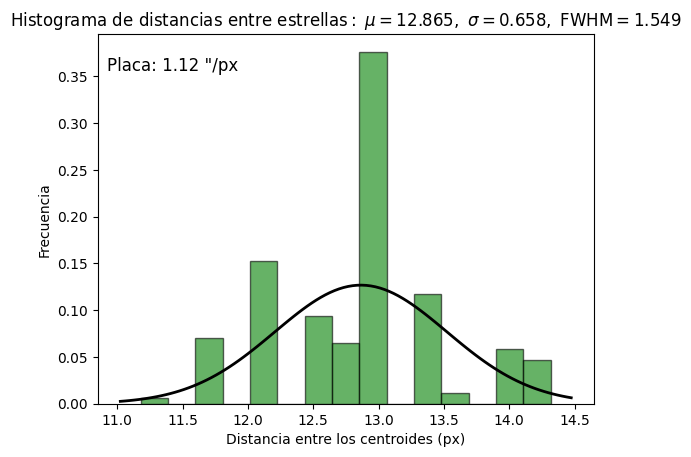

G_3_Altair_300824_21_43_DSC0035_Mascara
Se encontraron 8670 frames(.jpg) se procesarán del 6762 al 6936

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 12.533 pixeles, Desviación estándar (σ): 0.758 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.849 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.786

El parámetro de Fried es :5.11 cm 

El valor del seeing sin la corrección al cenit es de: 1.979


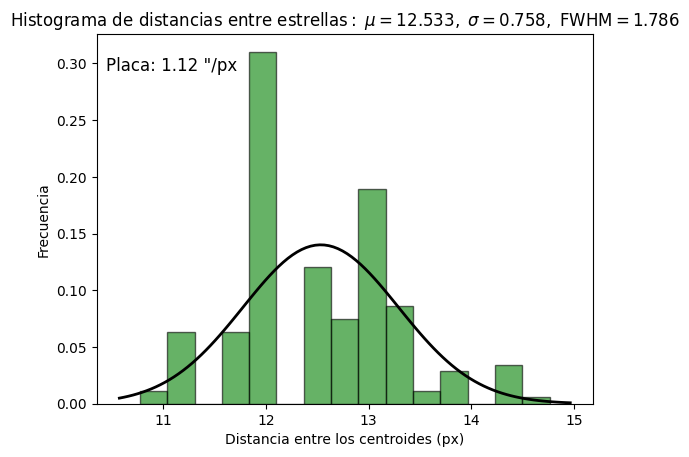

G_3_Altair_300824_21_47_DSC0037_Prisma
Se encontraron 7602 frames(.jpg) se procesarán del 5929 al 6081

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 817.937 pixeles, Desviación estándar (σ): 0.888 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.995 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.091

El parámetro de Fried es :4.22 cm 

El valor del seeing sin la corrección al cenit es de: 2.392


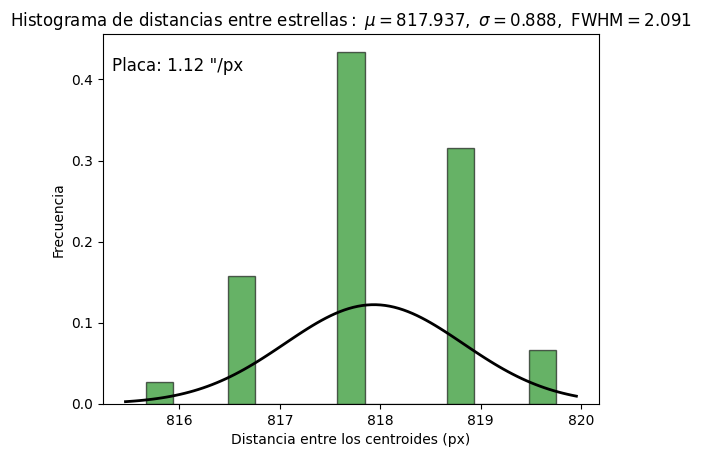

G_3_Altair_300824_21_54_DSC0039_Prisma
Se encontraron 4539 frames(.jpg) se procesarán del 3540 al 3631

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 817.955 pixeles, Desviación estándar (σ): 0.971 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.087 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.286

El parámetro de Fried es :3.80 cm 

El valor del seeing sin la corrección al cenit es de: 2.662


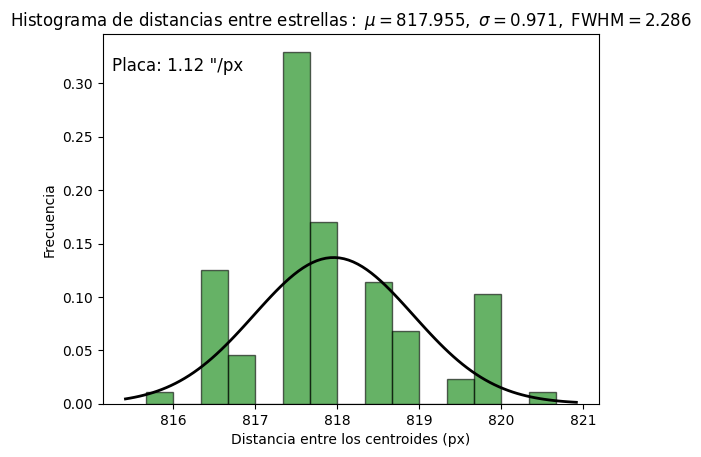

G_3_Formahault_200924_00_21_DSC0100_Prisma
Se encontraron 8385 frames(.jpg) se procesarán del 6540 al 6708

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 811.469 pixeles, Desviación estándar (σ): 1.026 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.150 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.417

El parámetro de Fried es :3.55 cm 

El valor del seeing sin la corrección al cenit es de: 2.846


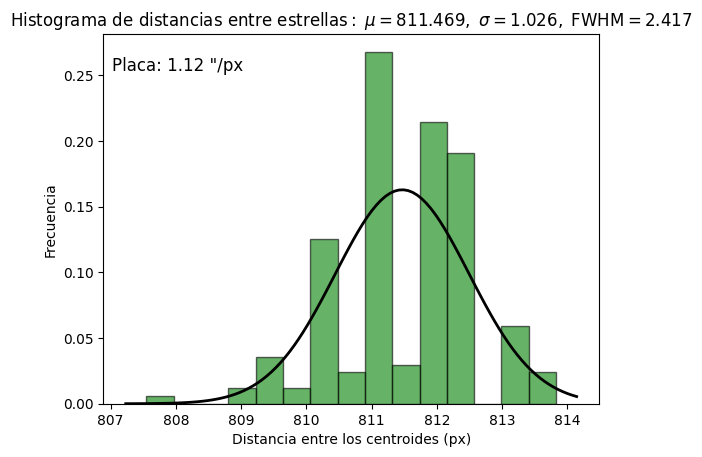

G_3_Formahault_200924_00_24_DSC0101_Mascara
Se encontraron 7779 frames(.jpg) se procesarán del 6067 al 6223

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 22.609 pixeles, Desviación estándar (σ): 0.699 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.783 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.647

El parámetro de Fried es :5.63 cm 

El valor del seeing sin la corrección al cenit es de: 1.796


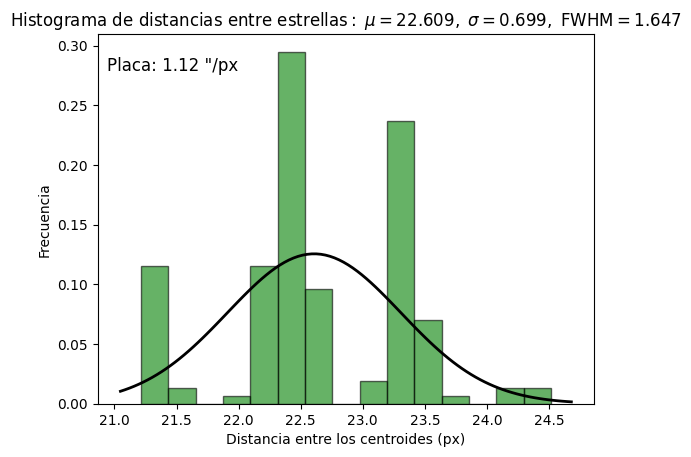

G_3_Zeta_Alquilae_300824_21_05_DSC0029_Prisma
Se encontraron 7782 frames(.jpg) se procesarán del 6069 al 6225

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 808.635 pixeles, Desviación estándar (σ): 1.400 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.568 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 3.298

El parámetro de Fried es :2.45 cm 

El valor del seeing sin la corrección al cenit es de: 4.132


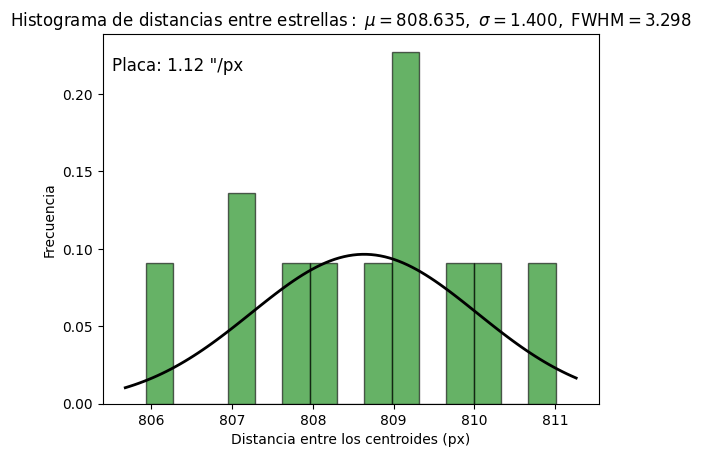

G_3_Zeta_Alquilae_300824_21_10_DSC0030_Prisma
Se encontraron 8403 frames(.jpg) se procesarán del 6554 al 6722

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 808.631 pixeles, Desviación estándar (σ): 0.878 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.983 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.068

El parámetro de Fried es :4.28 cm 

El valor del seeing sin la corrección al cenit es de: 2.360


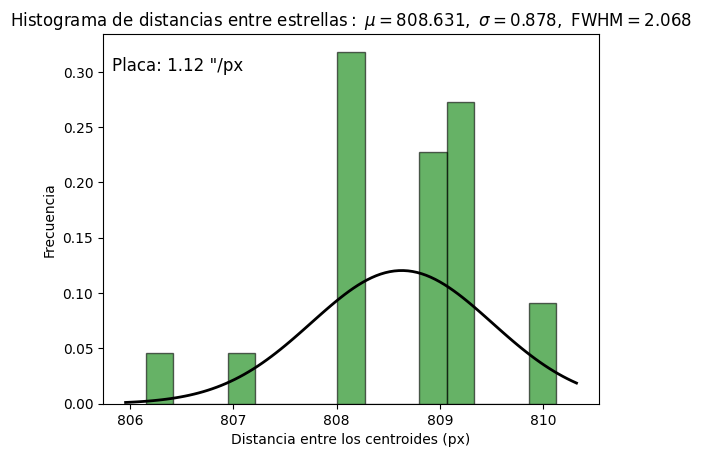

G_3_Zeta_Alquilae_300824_21_15_DSC0031_Prisma
Se encontraron 7530 frames(.jpg) se procesarán del 5873 al 6024

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 809.236 pixeles, Desviación estándar (σ): 1.037 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 1.162 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 2.442

El parámetro de Fried es :3.51 cm 

El valor del seeing sin la corrección al cenit es de: 2.882


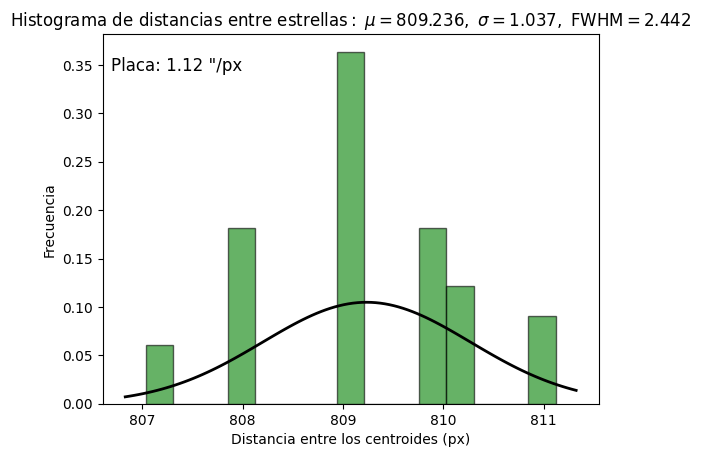

G_3_Zeta_Alquilae_300824_21_20_DSC0032_Mascara
Se encontraron 7653 frames(.jpg) se procesarán del 5969 al 6122

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 11.797 pixeles, Desviación estándar (σ): 0.820 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.918 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.930

El parámetro de Fried es :4.65 cm 

El valor del seeing sin la corrección al cenit es de: 2.173


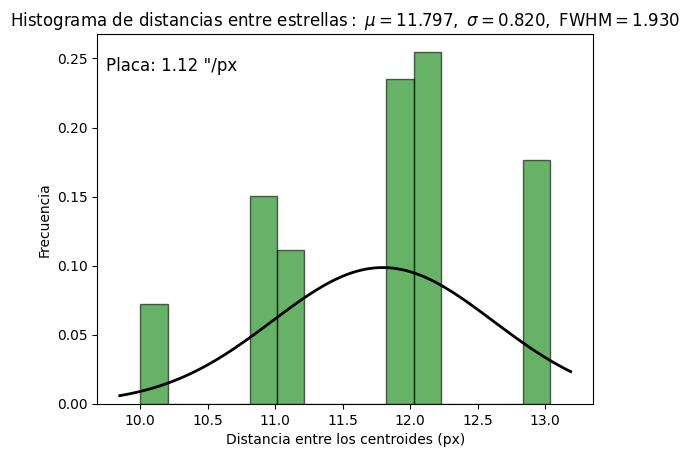

G_3_Zeta_Alquilae_300824_21_25_DSC0033_Mascara
Se encontraron 8220 frames(.jpg) se procesarán del 6411 al 6576

 :: CONSTRUYENDO EL HISTOGRAMA :: 

Media (mu): 11.315 pixeles, Desviación estándar (σ): 0.738 pixeles
Considerando el factor de escala 1.12 la desviación estándar sigma (σ): 0.826 sec
En la distribución normal el FWHM está dado por (2.355 * σ): 1.737

El parámetro de Fried es :5.28 cm 

El valor del seeing sin la corrección al cenit es de: 1.915


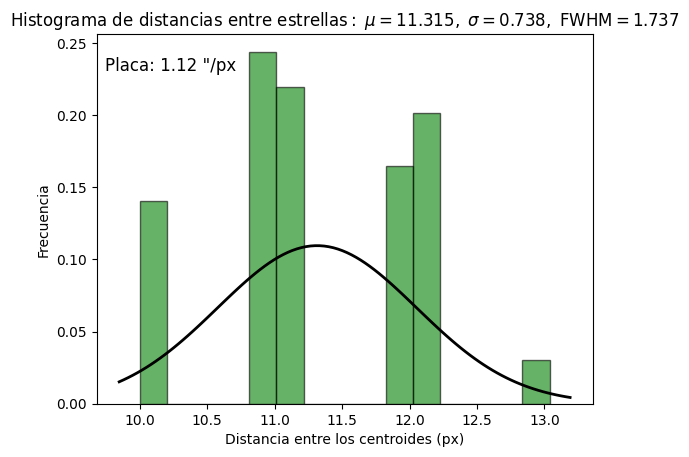

In [6]:
"""_____________________MAIN_________________________"""
folder = r"D:\Tecnicas_observacionales\Seeing\frames"  # <--------------AQUI SE CAMBIA LA RUTA DONDE SE ENCUENTRAN LOS FRAMES
output_folder = r"D:\Tecnicas_observacionales\Seeing"  # Carpeta de salida para los archivos .dat

files = np.sort([file for file in os.listdir(folder)])

values = np.zeros((len(files),6), dtype=object)
ff = -1

threshold = []
seeing = []
sigma = []
sigma_sec = []
fried = []
fwhm = []

for filename in files:
    ff+=1

    # Abrir carpeta donde se encuentran los frames del video
    carpeta = f"{folder}/{filename}"
    print(filename)

    # Busqueda de los archivos .jpg
    archivos = glob.glob(carpeta + r"/*.jpg")

    # Ordenar los archivos numéricamente por el número de frame en el nombre asi (0, 1, 2, 3, ...)
    archivos.sort(key=extract_frame_number)

    # Definir los frames que se procesaran, se escogieron unicamente los frames entre el 50% y el 80% para eliminar errores al inicio y fin
    start = int(len(archivos)*0.78)
    end = int(len(archivos)*0.8)

    nombres = []
    for j in archivos:
        if carpeta in j:
            nombres.append(j.replace(carpeta, ""))

    if nombres != []:
        l = len(nombres)
        print(f"Se encontraron {l} frames(.jpg) se procesarán del {start} al {end}")
        print("\n :: CONSTRUYENDO EL HISTOGRAMA :: \n")
    else:
        print("Su carpeta no tiene archivos .jpg")

    distances = []
    plotit = False #<-----------------Cambiar a True para visualizar los frames con las estrellas identificadas
    thrhld = 5     #<-----------------Cambiar el valor de i para ajustar el umbral del threshold

    for k in range(start, end):
        # Usar la función en un frame
        dis = identify_stars_and_distance(archivos[k],thrhld, plotit)

        distances.append(dis)  

        if dis!=0:
            plotit=False
    # print(distances)
    distances = np.array(distances)
    no_stars = len(np.where(distances==0)[0])
    # print(f'No se encontraron estrellas en {no_stars} frames, es decir en el {round(no_stars/(end-start+1)*100,2)}% de ellos')

    distances = distances[np.where(distances!=0)]

    # Ajuste de los datos a una distribución normal
    mu, std = norm.fit(distances)
    # Normalizar los valores del histograma
    weights = np.ones_like(distances) / len(distances)
    # Graficar el histograma con las distancias
    count, bins, ignored = plt.hist(distances, weights=weights, bins=15, alpha=0.6, color="g", edgecolor="black")

    # Graficar la función de densidad de probabilidad (PDF) ajustada
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # Normalizar la PDF para que se ajuste al histograma
    bin_width = bins[1] - bins[0]
    p_normalized = p * bin_width  # Ajuste el área de la PDF al histograma
    plt.plot(x, p_normalized, "k", linewidth=2)

    """_____________________SCALE________________________"""

    # scale_size = 0.358  # segundos de arco por px ('' /px)
    scale_size = 1.12 # segundos de arco por px ('' /px)
    """__________________________________________________"""

    # Mostrar los valores de mu y sigma
    print(f"Media (mu): {mu:.3f} pixeles, Desviación estándar (σ): {std:.3f} pixeles")
    sigma_sc = std*scale_size
    print(f"Considerando el factor de escala {scale_size} la desviación estándar sigma (σ): {sigma_sc:.3f} sec")
    print(f"En la distribución normal el FWHM está dado por (2.355 * σ): {2.355*std:.3F}")

    # Parametro de Fried
    """
    Consideraciones para la ecuación del parámetro de Freid:
    206264.8 el factor de conversion de arcsec to rad ( "/rad)
    se asume un r_0 para un solo sentido, la ecuación transversal
    """
    # r_0 = (((0.358 * (lamb / std) ** 2) ** 3) / Dhole) ** (1 / 5)
    r_0 = (((sigma_sc/206264.8)**2)/((2*lamb**2)*(0.179*Dhole**(-1/3)-0.145*dsep**(-1/3))))**(-3/5)
    print(f"\nEl parámetro de Fried es :{r_0:.2f} cm \n")

    # Seeing sin corregir por cenit
    theta = 0.98 * (lamb / r_0) * 206264.8
    fuwhama = 2.355 * std
    print(f"El valor del seeing sin la corrección al cenit es de: {theta:.3f}")

    # Grafico
    plt.title(r"$\mathrm{Histograma\ de\ distancias\ entre\ estrellas:}\ \mu=%.3f,\ \sigma=%.3f,\ \mathrm{FWHM}=%.3f$" % (mu, std, fuwhama))
    plt.xlabel("Distancia entre los centroides (px)")
    plt.ylabel("Frecuencia")
    plt.text(0.15, 0.9, f"Placa: {scale_size} \"/px", transform=plt.gca().transAxes, fontsize=12, color='black', ha='center')
    plt.show()

    threshold.append((filename, thrhld))
    sigma.append((filename, std))
    sigma_sec.append((filename,sigma_sc))
    fried.append((filename, r_0))
    fwhm.append((filename, fuwhama))
    seeing.append((filename, theta))

# Guardar los datos en un archivo .dat dentro de la misma carpeta
output_file = os.path.join(output_folder, f"seeing_sigma.dat")

with open(output_file, "w") as f:
    f.write("# Filename\tThreshold\tSigma(px)\tSigma(sec)\tr_0(cm)\tFWHM\tSeeing_sin_corregir\n")  # Usar \t para tabulaciones
    for (file_threshold, value_threshold),(file_sigma, value_sigma), (file_sigma_sec, value_sigma_sec), (file_fried, value_fried),(file_fwhm, value_fwhm), (file_seeing, value_seeing) in zip(threshold,sigma, sigma_sec, fried, fwhm, seeing):
        f.write(f"{file_seeing}\t{value_threshold:.3f}\t{value_sigma:.3f}\t{value_sigma_sec:.3f}\t{value_fried:.3f}\t{value_fwhm:.3f}\t{value_seeing:.3f}\n")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

# Cargar datos
df = pd.read_csv('DIMM_data.txt', sep='\t')

# Convertir las horas a formato datetime ajustando rango
df["Hora_datetime"] = pd.to_datetime(df["Hora"], format="%H:%M")
df["Hora_datetime"] = df["Hora_datetime"].apply(lambda x: x + timedelta(days=1) if x.hour < 18 else x)

# Ordenar por hora
df = df.sort_values(by="Hora_datetime")

# Graficar con barras de error y ajustes solicitados
plt.figure(figsize=(6, 4))
plt.errorbar(
    df["Hora_datetime"],
    df["Seeing"],
    yerr=df["sigma (px) software"],
    fmt="o--",                        # Línea discontinua con marcadores
    ecolor="lightgray",               # Barras de error más claras
    capsize=3,                        # Extensión de las barras de error
    markerfacecolor="none",           # Marcadores sin relleno
    markeredgecolor="black",          # Bordes de los marcadores en negro
    color="black",                    # Línea punteada en negro
    linestyle="--"                    # Estilo de línea discontinua
    
)

# Ajustar formato del eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlim([datetime.strptime("18:00", "%H:%M"), datetime.strptime("01:00", "%H:%M") + timedelta(days=1)])
plt.ylim(0, 8.5)

# Agregar etiquetas
plt.xlabel("Hora (UTC - 5)")
plt.ylabel("Seeing (segundos de arco)")

# Agregar cuadrícula con subdivisiones
plt.grid(which="both", alpha=0.4)     # Cuadrícula principal
plt.minorticks_on()                  # Activar ticks menores
plt.grid(which="minor", alpha=0.2, linestyle=":")  # Cuadrícula secundaria con estilo punteado

# Mostrar gráfico
plt.tight_layout()
plt.show()
